<h1 align="center">Wikipedia Application Prediction</h1>

# Prediction by total duration

In [1]:
# Notebook configuration, modules import, functions

# plots in the notebook
%matplotlib inline

# Make graphs more readable
import matplotlib
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
from common import *

In [2]:
apps, worker_amounts = parse_strong_scaling(reduce_outliers=True)

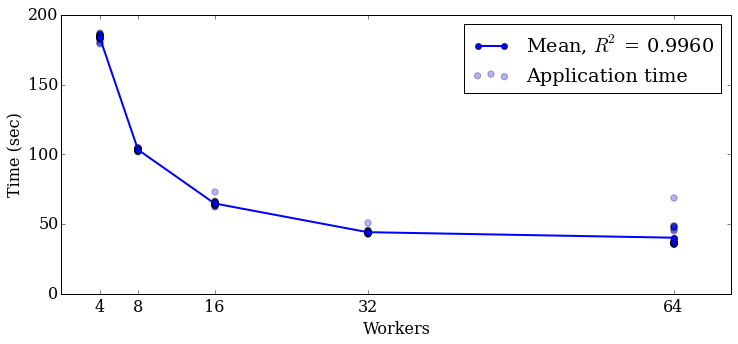

In [3]:
def get_lists_by_wa(apps, fn, fn_results=None):
    """ Apply fn to every app and returns a list of the results indexed by worker amount.
    Optionally run fn_results in every worker amount result.
    """
    lists = {}
    [lists.setdefault(a.workers, []).append(fn(a)) for a in apps]
    results = [np.array(lists[wa]) for wa in sorted(lists)]
    if fn_results is None:
        return results
    else:
        return np.array([fn_results(result) for result in results])

plt.subplots(figsize=(12,5))

app_durations = get_lists_by_wa(apps, lambda a: a.duration)
app_means = np.array([d.mean() for d in app_durations])
flat_worker_amounts = np.array([a.workers for a in apps])
flat_durations = np.array([a.duration for a in apps])

# Mean r-squared value
def get_mean(worker): return app_means[worker_amounts.index(worker)]
r2 = calc_r2_fn(flat_worker_amounts, flat_durations, get_mean)
mean_label = get_r2_label('Mean', r2)

plt.scatter(flat_worker_amounts, flat_durations/1000, s=40, alpha=0.3, label='Application time')
plt.plot(worker_amounts, app_means/1000, '-o', label=mean_label)

plt.xticks(worker_amounts)
plt_setup('Workers', 'Time (sec)')
plt.legend()
plt.show()

## Regression $y = ab^{x}$

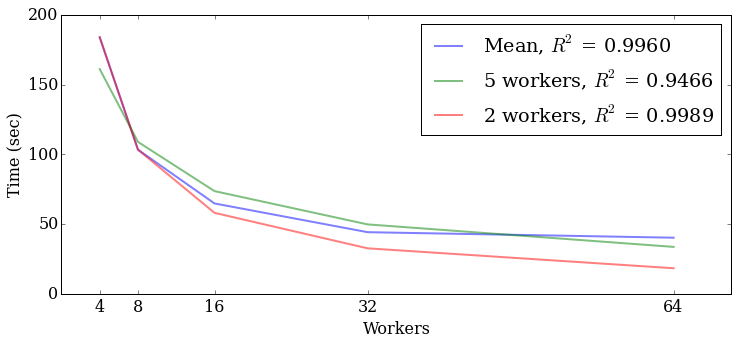

In [4]:
def calc_lin_reg(xs, ys):
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    return slope, intercept

def calc_lin_reg_fn(xs, ys):
    slope, intercept = calc_lin_reg(xs, ys)
    return lambda x: intercept + slope*x

def calc_yabx_reg_fn(xs, ys):
    xs_log, ys_log = np.log2(xs), np.log2(ys)
    slope, intercept = calc_lin_reg(xs_log, ys_log)
    return lambda x: 2**intercept * x**slope

plt.subplots(figsize=(12,5))
plt.plot(worker_amounts, app_means/1000, label=mean_label, alpha=0.5)

def plot_regression(workers2use):
    _apps = (a for a in apps if a.workers in workers2use)
    points = ((a.workers, a.duration) for a in _apps)
    xs, ys = zip(*points)
    fn_reg = calc_yabx_reg_fn(xs, ys)
    r2 = calc_r2_fn(xs, ys, fn_reg)
    label = get_r2_label('{:d} workers'.format(len(workers2use)), r2)
    regression = np.array([fn_reg(wa) for wa in worker_amounts])
    plt.plot(worker_amounts, regression/1000 , label=label, alpha=0.5)
    
for workers2use in (worker_amounts, worker_amounts[:2]):
    plot_regression(workers2use)

plt.xticks(worker_amounts)
plt_setup('Workers', 'Time (sec)')
plt.legend()
plt.show()

TODO:
- Prediction like in the reduce phase
- Prediction with a second-degree polynomial

# Prediction by stages' sum

Considering only the sum of the stages is not enough as we can notice in the graph below:

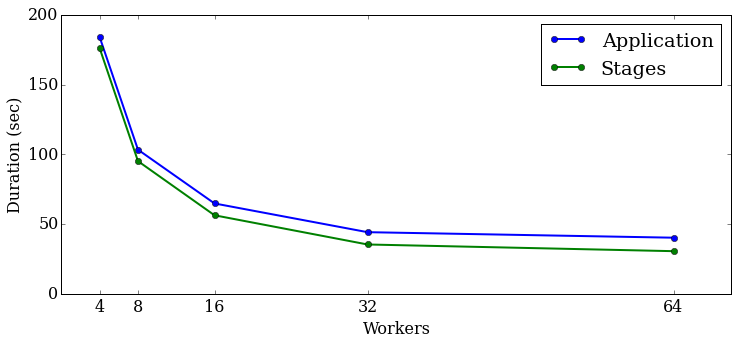

In [5]:
plt.subplots(figsize=(12,5))
plt.plot(worker_amounts, app_means/1000, '-o', label='Application')

def get_stages_duration(app):
    return sum(stage.duration for stage in app.stages)

stg_durations = get_lists_by_wa(apps, get_stages_duration)
stg_means = [d.mean()/1000 for d in stg_durations]
plt.plot(worker_amounts, stg_means, '-o', label='Stages')

plt_setup('Workers', 'Duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

## Adding initialization delay

In [6]:
def get_delay(app):
    return app.stages[0].start - app.start

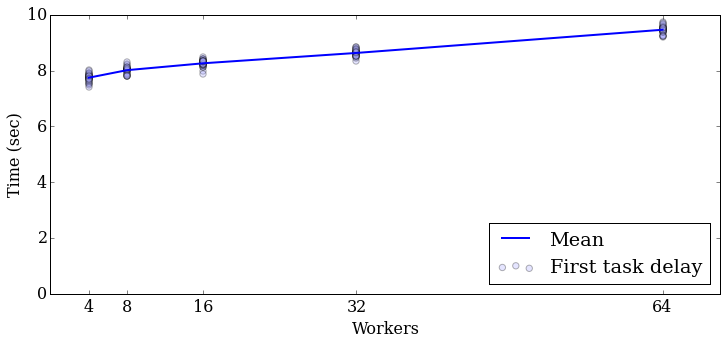

In [7]:
plt.subplots(figsize=(12,5))

delays = get_lists_by_wa(apps, get_delay)
delay_means = [d.mean()/1000 for d in delays]
plt.plot(worker_amounts, delay_means, label='Mean')

xs = [a.workers for a in apps]
ys = [get_delay(a)/1000 for a in apps]
plt.scatter(xs, ys, s=40, alpha=0.3, c='#AAAAFF', label='First task delay')

plt_setup('Workers', 'Time (sec)')
plt.xticks(worker_amounts)
plt.legend(loc='lower right')
plt.show()

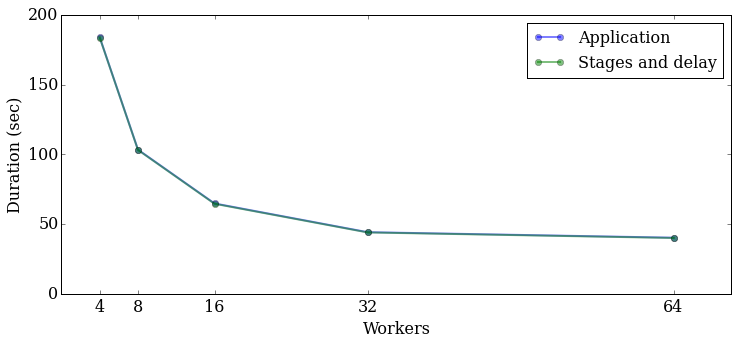

In [8]:
plt.subplots(figsize=(12,5))

stg_delay_durations = [stages + delay for stages, delay in zip(stg_durations, delays)]
stg_means = np.array([d.mean() for d in stg_delay_durations])
plt.plot(worker_amounts, app_means/1000, '-o', alpha=0.5, label='Application')
plt.plot(worker_amounts, stg_means/1000, '-o', alpha=0.5, label='Stages and delay')

plt_setup('Workers', 'Duration (sec)')
plt.xticks(worker_amounts)
plt.legend(loc=0, fontsize=16)
plt.show()

# TODO graph with the difference between these two curves that seem like one only.

### Delay prediction

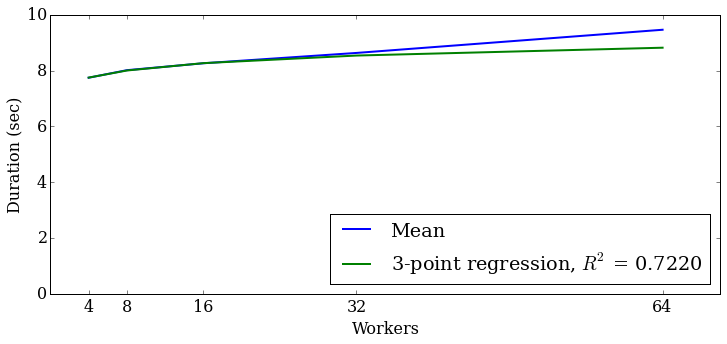

In [9]:
plt.subplots(figsize=(12,5))
plt.plot(worker_amounts, delay_means, label='Mean')

# Curvilinear regression y = ab^x with 4, 8 and 16 workers
_apps = [a for a in apps if a.workers <= worker_amounts[2]]
xs = np.array([a.workers for a in _apps])
ys = np.array([get_delay(a) for a in _apps])
xs_log, ys_log = np.log2(xs), np.log2(ys)
slope, intercept, r_value, p_value, std_err = stats.linregress(xs_log, ys_log)
def curv_reg(x): return 2**intercept * x**slope
r2 = calc_r2_fn(xs, ys, curv_reg)
label = get_r2_label('3-point regression', r2)
plt.plot(worker_amounts, [curv_reg(x)/1000 for x in worker_amounts], label=label)

plt.legend(loc='lower right')
plt.xticks(worker_amounts)
plt_setup('Workers', 'Duration (sec)')
plt.ylim(0, 10)
plt.show()

# TODO improve curvilinear function

### Profiling phase

In [10]:
apps_sss, worker_amounts_sss = parse_sss()

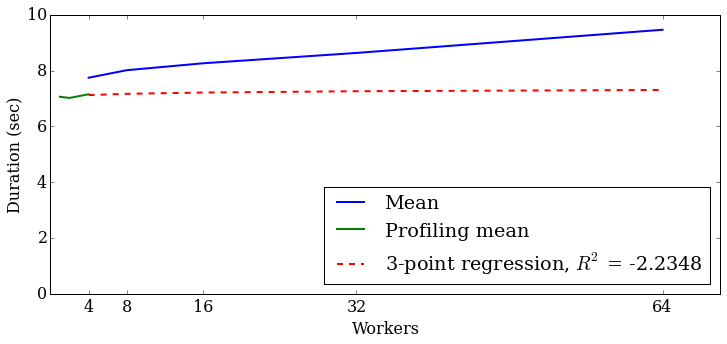

In [11]:
plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, delay_means, label='Mean')

delays_sss = get_lists_by_wa(apps_sss, get_delay)
delay_means_sss = [d.mean()/1000 for d in delays_sss]
plt.plot(worker_amounts_sss, delay_means_sss, label='Profiling mean')

# Curvilinear regression y = ab^x with 1, 2 and 4 workers
xs = np.log2([a.workers for a in apps_sss])
ys = np.log2([get_delay(a) for a in apps_sss])
slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
def delay_reg(x): return 2**intercept * x**slope
r2 = calc_r2_fn([a.workers for a in apps], [a.duration for a in apps], delay_reg)
label = get_r2_label('3-point regression', r2)
plt.plot(worker_amounts, [delay_reg(x)/1000 for x in worker_amounts], '--', label=label)

plt.legend(loc='lower right')
plt.xticks(worker_amounts)
plt_setup('Workers', 'Duration (sec)')
plt.ylim(0, 10)
plt.show()

delay_slope, delay_intercept = slope, intercept

In [25]:
def mean_model(workers, tasks, mean):
    threads = 2 * workers
    return np.ceil(tasks/threads) * mean

# Map model
def two_mean_model(workers, tasks, high_mean, low_mean):
    """
      workers: amount of workers
        tasks: number of tasks
    high_mean: mean duration of the first tasks
     low_mean: mean duration of the remaining tasks
    """
    total_time = high_mean  # all the workers process their first task
    threads = 2 * workers
    total_time += mean_model(workers, tasks - threads, low_mean)
    return total_time

# Reduce model
def linear_mean_model(slope, intercept, workers, tasks):
    mean = slope * workers + intercept
    return mean_model(workers, tasks, mean)

# From Map and Reduce notebooks
n_tasks = 362
high_mean = 9185.3667
low_mean = 3037.6333
reduce_slope = 26.3055
reduce_intercept = 534.2397
reduce_tasks = 200

def map_model(workers): return two_mean_model(workers, n_tasks, high_mean, low_mean)
def reduce_model(workers): return linear_mean_model(reduce_slope, reduce_intercept, workers, reduce_tasks)
def delay_model(workers): return 2**delay_intercept * workers**delay_slope
def app_model(w): return map_model(w) + reduce_model(w) + delay_model(w)

# Improved map model
map_slope = 33.9231254933
map_intercept = 3408.85
def map_model2(workers): return linear_mean_model(map_slope, map_intercept, workers, n_tasks)
def app_model2(w): return map_model2(w) + reduce_model(w) + delay_model(w)

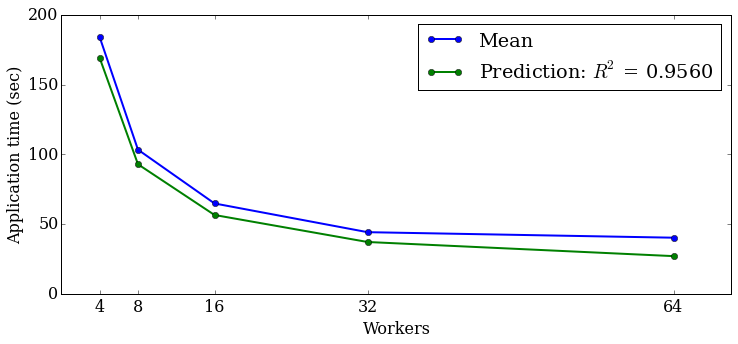

In [26]:
def plot_app_prediction(model):
    plt.subplots(figsize=(12,5))

    _durations = {wa:[] for wa in worker_amounts}
    [_durations[a.workers].append(a.duration) for a in apps]
    means = [np.mean(_durations[wa])/1000 for wa in worker_amounts]
    plt.plot(worker_amounts, means, '-o', label='Mean')

    prediction = [model(x)/1000 for x in worker_amounts]
    r2 = calc_r2(worker_amounts, means, prediction)
    label = 'Prediction' + r': $R^{2}$' + ' = {:.4f}'.format(r2)
    plt.plot(worker_amounts, prediction, '-o', label=label)

    plt.xticks(worker_amounts)
    plt_setup('Workers', 'Application time (sec)')
    plt.legend()

plot_app_prediction(app_model)
plt.show()

The time interval between the application start and the beginning of the first task is depicted below.

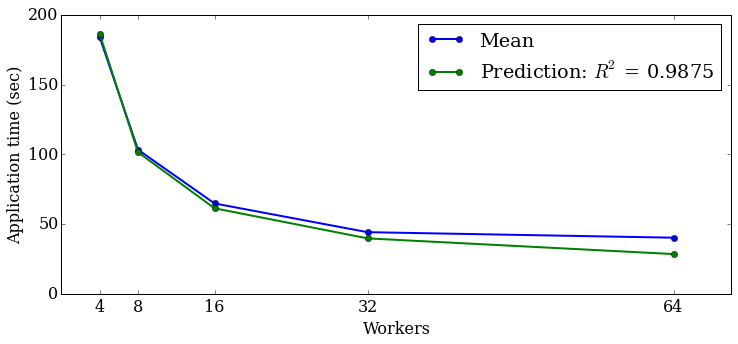

In [27]:
plot_app_prediction(app_model2)
plt.show()

## Error details

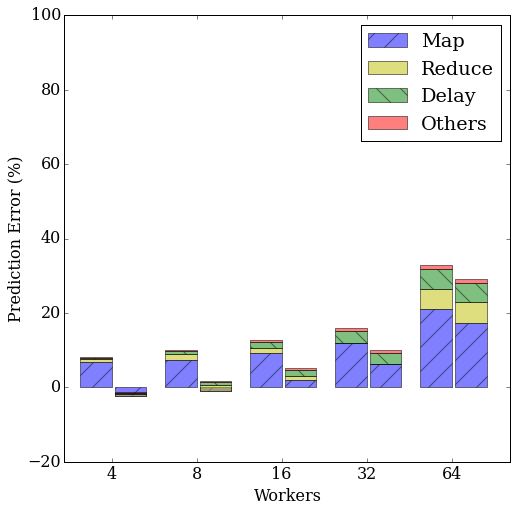

In [68]:
def calc_mean(values): return values.mean()
def get_duration(app): return app.duration

def get_stage_means(apps, stage):
    return get_lists_by_wa(apps, lambda a: a.stages[stage].duration, calc_mean)

# Real measurements
map_means = get_stage_means(apps, 0)
reduce_means = get_stage_means(apps, 1)
delay_means = get_lists_by_wa(apps, get_delay, calc_mean)
total_means = get_lists_by_wa(apps, get_duration, calc_mean)

def plot_errors(map_model, reduce_model, delay_model, app_model, xs_offset=0):
    def predict(model):
        return np.array([model(w) for w in worker_amounts])

    # Model predictions
    map_means_model = predict(map_model)
    reduce_means_model = predict(reduce_model)
    delay_means_model = predict(delay_model)
    total_means_model = predict(app_model)

    # Difference between executed and predicted values
    map_diff = map_means - map_means_model
    reduce_diff = reduce_means - reduce_means_model
    delay_diff = delay_means - delay_means_model
    total_diff = total_means - total_means_model - map_diff - reduce_diff - delay_diff
    
    width = 0.75
    wa_log = np.log2(worker_amounts)

    def plot_stacked_bars(ys, bottom, label, color, hatch=None):
        percentage = ys/total_means * 100
        if xs_offset == 1:
            xs = 2 * wa_log - xs_offset - width/4
        else:
            xs = 2 * wa_log - xs_offset
        plt.bar(xs, percentage, width, bottom, label=label,
                color=color, alpha=0.5, hatch=hatch)
        return np.add(bottom, percentage)

    bottom = np.zeros(len(worker_amounts), dtype=np.int)
    bottom = plot_stacked_bars(map_diff, bottom, 'Map', 'b', '/')
    bottom = plot_stacked_bars(reduce_diff, bottom, 'Reduce', 'y')
    bottom = plot_stacked_bars(delay_diff, bottom, 'Delay', 'g', '\\')
    plot_stacked_bars(total_diff, bottom, 'Others', 'r')

    xticks_pos = 2 * (wa_log) - 2 + width
    plt_setup('Workers', 'Prediction Error (%)')
    xmax = 2*wa_log[-1] - 1 + 1.5*width
    plt.xlim(wa_log[0] - width/2, xmax)
    plt.ylim(-20, 100)
    if xs_offset == 2:
        plt.xticks(xticks_pos, worker_amounts)
        plt.legend()
    
plt.subplots(figsize=(8,8))
plot_errors(map_model, reduce_model, delay_model, app_model, 2)
plot_errors(map_model2, reduce_model, delay_model, app_model2, 1)
plt.show()

In [69]:
#def map_model(workers): return linear_mean_model(33.9231254933, 3408.85, workers, n_tasks)
def map_model(workers): return two_mean_model(workers, n_tasks, high_mean, low_mean)

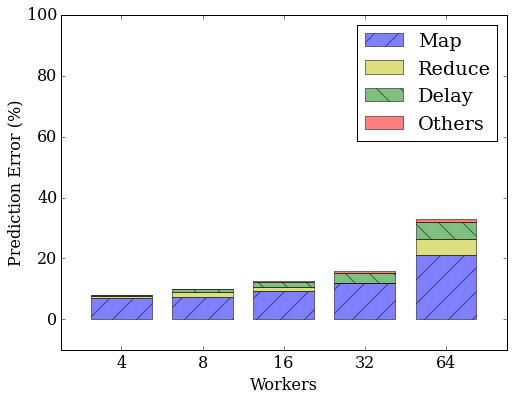

In [70]:
def calc_mean(values): return values.mean()
def get_duration(app): return app.duration

def get_stage_means(apps, stage):
    return get_lists_by_wa(apps, lambda a: a.stages[stage].duration, calc_mean)

# Real measurements
map_means = get_stage_means(apps, 0)
reduce_means = get_stage_means(apps, 1)
delay_means = get_lists_by_wa(apps, get_delay, calc_mean)
total_means = get_lists_by_wa(apps, get_duration, calc_mean)

def predict(model):
    return np.array([model(w) for w in worker_amounts])

# Model predictions
map_means_model = predict(map_model)
reduce_means_model = predict(reduce_model)
delay_means_model = predict(delay_model)
total_means_model = predict(app_model)

# Difference between executed and predicted values
map_diff = map_means - map_means_model
reduce_diff = reduce_means - reduce_means_model
delay_diff = delay_means - delay_means_model
total_diff = total_means - total_means_model - map_diff - reduce_diff - delay_diff

plt.subplots(figsize=(8,6))
width = 0.75
wa_log = np.log2(worker_amounts)

def plot_stacked_bars(ys, bottom, label, color, hatch=None):
    percentage = ys/total_means * 100
    plt.bar(wa_log, percentage, width, bottom, label=label, color=color, alpha=0.5, hatch=hatch)
    return np.add(bottom, percentage)

bottom = np.zeros(len(worker_amounts), dtype=np.int)
bottom = plot_stacked_bars(map_diff, bottom, 'Map', 'b', '/')
bottom = plot_stacked_bars(reduce_diff, bottom, 'Reduce', 'y')
bottom = plot_stacked_bars(delay_diff, bottom, 'Delay', 'g', '\\')
plot_stacked_bars(total_diff, bottom, 'Others', 'r')

plt.xticks(wa_log + width/2, worker_amounts)
plt_setup('Workers', 'Prediction Error (%)')
plt.xlim(wa_log[0] - width/2, wa_log[-1] + 1.5*width)
plt.ylim(-10, 100)
plt.legend(loc=0)
plt.show()

# Conclusion

The prediction error increases as workers are added, mainly because of the map and delay errors. All the map predictions are higher, which suggests lower hardware performance during the profiling phase. Running the profiling phase right before the final execution may overcome the cloud performance variability issue. As to the delay prediction, the profiling data is not enough for a good regression, specially because the delay decreases from one to two workers. Using more worker amounts in the profiling phase might help (e.g.: 1, 2, 3 and 4 instead of 1, 2 and 4).